### Model training updates

update 1 - retraining the model with the clean esec data (non flows, non rockfalls, non earthquakes). 

update 2 - June 20, 2025 - retraining the model with 2502 near field  (0-50 km) explosions waveforms that were classified as surface events and earthquakes. 

update 3 - retraining the model by assigning higher penalities whenever there is a confusion between explosion and surface events. 

In [1]:
%load_ext autoreload
%autoreload 2

# === Standard Libraries ===
import os
import sys
import random
import json
from typing import Any

# === Scientific Libraries ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

# === Signal Processing ===
import scipy
from scipy import signal
from scipy.signal import butter, filtfilt, correlate

# === Seismology Libraries ===
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

# === Machine Learning Libraries ===
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# === File Handling ===
import h5py

# === Custom Modules ===
module_path = os.path.abspath(os.path.join('../scripts'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.model_selection import train_test_split
from neural_network_architectures import (
     QuakeXNet_1d, QuakeXNet_2d, SeismicCNN_1d, SeismicCNN_2d )


# === Seismology Client ===
client = Client('IRIS')

from utils import extract_waveforms
from utils import compute_spectrogram
from utils import normalize_spectrogram_minmax
from utils import return_train_val_loaders
from utils import plot_confusion_matrix_and_cr
from utils import train_model
from utils import train_model_weighted
from utils import WaveformPreprocessor


import json

cuda


## Defining some common parameters

In [3]:
# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = - 40
shifting = True

# training parameters
train_split = 70                                      

val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()


num_channels = 3
# new sampling rate
fs = 50

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100

# randomly starting between -40 to -5s
start = -40

## 1. Additional surface events per station. 

###  I downloaded additional surface event data by downloading from more stations from event to supplement existing data.  the step below is just processing those additionally downloaded waveforms and these will be added later to the the total dataset. 

In [4]:
def process_surface_events(data_path, ids_path, fs=50, original_fs = 100, lowcut=1, highcut=20, window_length=100, taper_alpha=0.1, random_offset=(-40, -5)):
    """
    Processes surface event data by applying tapering, bandpass filtering, resampling, and normalization.
    
    Args:
        data_path (str): Path to the surface event data (.npy file).
        ids_path (str): Path to the surface event IDs (JSON file).
        fs (int): Sampling rate for resampling.
        lowcut (float): Low cutoff frequency for bandpass filter.
        highcut (float): High cutoff frequency for bandpass filter.
        window_length (int): Length of the waveform window (in seconds).
        taper_alpha (float): Alpha value for the Tukey window.
        random_offset (tuple): Range of random offsets for slicing data.
        
    Returns:
        list: Processed waveform data.
        list: Corresponding event IDs.
    """
    # Load data and IDs
    surface_data = np.load(data_path, allow_pickle=True)
    with open(ids_path, "r") as file:
        surface_ids = json.load(file)


    processed_data = []
    processed_ids = []

    # Process each event
    for i in tqdm(range(len(surface_data)), desc="Processing events"):
        try:
            event_data = surface_data[i]
            
            orig_fs = 100
            
            # Randomly select a window of the specified length
            random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs
            
            # assuming the onset at 90s
            start_idx = int(90 * orig_fs) + random_shift
            end_idx = start_idx + int(window_length * orig_fs)
            
    
            # Handle boundary conditions
            max_idx = event_data.shape[-1]
            if end_idx > max_idx:
                end_idx = max_idx
                start_idx = end_idx - int(window_length * orig_fs)
            if start_idx < 0:
                start_idx = 0
                end_idx = int(window_length * orig_fs)
                
                
            sliced = event_data[:, start_idx:end_idx]
            sliced_tensor = torch.tensor(sliced, dtype=torch.float32)

            
            processor = WaveformPreprocessor(
            input_fs=original_fs,
            target_fs=fs,
            lowcut=lowcut,
            highcut=highcut)
            
            processed = processor(sliced_tensor)  # (C, T)
          
        
            if processed.shape[-1] != int(window_length*fs):
                print('error')
                continue

            x = processed.numpy()
            
            if len(x) == 3:  # Ensure the event has three components
                processed_data.append(x)
                processed_ids.append(surface_ids[i])

        except Exception as e:
            # Log or print the exception if needed
            print(f"Error processing event {i}: {e}")
            continue

    return processed_data, processed_ids


# Example usage
data_path = '../../data/new_curated_surface_event_data.npy'
ids_path = '../../data/new_curated_surface_event_ids.json'

processed_additional_su, processed_additional_su_id = process_surface_events(data_path, ids_path)

print(f'Length of additional surface event waveforms {len(processed_additional_su)}')

Processing events: 100%|██████████| 6495/6495 [00:10<00:00, 600.27it/s]

Length of additional surface event waveforms 6487


## 2. Original PNW data

In [5]:
#data files
file_noise="/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")


# accessing the exotic metadata
exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")


# accessing the data files
metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")


# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]

In [6]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

## Note that we are only selecting three components from each class

In [7]:
number_data_per_class = len(df_su)
# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)



number_data_per_class = 15000
# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



number_data_per_class = len(df_exp)
# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)


number_data_per_class = 17000
# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)

  0%|          | 8/15000 [00:00<03:12, 78.02it/s]

(3778, 3, 5000)


  0%|          | 16/13638 [00:00<01:31, 148.75it/s]

(10566, 3, 5000)


  0%|          | 0/17000 [00:00<?, ?it/s]

(8771, 3, 5000)


100%|██████████| 17000/17000 [03:33<00:00, 79.67it/s]


(10480, 3, 5000)


## 3. ESEC waveforms (1866 waveforms)

In [8]:
df = pd.read_csv('../../data/curated_esec_catalog_for_retraining.csv',index_col = 0)
print(len(df))

1866


### In the following cell, we are loading 270s of the three component esec waveforms, (70s before and 200s after), and resampling them to 100 Hz as required for further processing

In [9]:
esec_data = []
esec_ids = []

for i in tqdm(range(len(df))):
    try:
        event_id = df['event_id'].iloc[i]
        station = df['station'].iloc[i]

        # Find all vertical component files for the event and station
        files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*")

        if len(files) == 3:
            st = obspy.Stream()
            for file in files:
                st += obspy.read(file)
            
            
            st.resample(100)

            # Convert to NumPy array and clip length to 27000 samples (if possible)
            arr = np.stack([tr.data[:27000] for tr in st])
            esec_data.append(arr)
            esec_ids.append(event_id)

    except Exception as e:
        print(f"Error on index {i}, event {df['event_id'].iloc[i]}: {e}")
        continue


100%|██████████| 1866/1866 [00:23<00:00, 77.79it/s]


In [10]:
esec_data = np.array(esec_data)
esec_ids = np.array(esec_ids)

In [11]:
random_offset=(-40, -5)
fs=50 
original_fs = 100
lowcut=1
highcut=20
window_length=100
taper_alpha=0.1
orig_fs = 100

processed_esec_data = []
processed_esec_ids = []

for i in tqdm(range(len(esec_data))):
    event_data = esec_data[i]
    random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs


    # assuming the onset at 90s
    start_idx = int(90 * orig_fs) + random_shift
    end_idx = start_idx + int(window_length * orig_fs)

    # Handle boundary conditions
    max_idx = event_data.shape[-1]
    if end_idx > max_idx:
        end_idx = max_idx
        start_idx = end_idx - int(window_length * orig_fs)
    if start_idx < 0:
        start_idx = 0
        end_idx = int(window_length * orig_fs)



    sliced = event_data[:, start_idx:end_idx]
    sliced_tensor = torch.tensor(sliced, dtype=torch.float32)


    processor = WaveformPreprocessor(
    input_fs=original_fs,
    target_fs=fs,
    lowcut=lowcut,
    highcut=highcut)

    processed = processor(sliced_tensor)  # (C, T)


    if processed.shape[-1] != int(window_length*fs):
        print('error')
        continue

    x = processed.numpy()
    
    if len(x) == 3:  # Ensure the event has three components
        processed_esec_data.append(x)
        processed_esec_ids.append(esec_ids[i])
        
    

100%|██████████| 1866/1866 [00:03<00:00, 615.16it/s]


## 4. New near field explosion data

In [12]:
new_exp_df = pd.read_csv('../../data/curated_new_explosions_data_for_retraining.csv',index_col = 0)

In [13]:
print(len(new_exp_df))

2502


In [14]:
new_exp_data = []
new_exp_ids = []

for i in tqdm(range(len(new_exp_df))):
    try:
        event_id = new_exp_df['event_id'].iloc[i]
        station = new_exp_df['station'].iloc[i]

        # Find all vertical component files for the event and station
        files = glob(f"../../data/pnw_new_explosion_2023_2025/waveforms/{event_id}/*{station}*")

        if len(files) == 3:
            st = obspy.Stream()
            for file in files:
                st += obspy.read(file)
            
            
            st.resample(100)

            # Convert to NumPy array and clip length to 27000 samples (if possible)
            arr = np.stack([tr.data[:27000] for tr in st])
            new_exp_data.append(arr)
            new_exp_ids.append(event_id)

    except Exception as e:
        print(f"Error on index {i}, event {new_exp_df['event_id'].iloc[i]}: {e}")
        continue


100%|██████████| 2502/2502 [00:20<00:00, 119.15it/s]


In [15]:
new_exp_data = np.array(new_exp_data)
new_exp_ids = np.array(new_exp_ids)

In [16]:
processed_new_exp_data = []
processed_new_exp_ids = []

for i in tqdm(range(len(new_exp_data))):
    event_data = new_exp_data[i]
    random_shift = np.random.randint(random_offset[0], random_offset[1]) * orig_fs


    # assuming the onset at 90s
    start_idx = int(70 * orig_fs) + random_shift
    end_idx = start_idx + int(window_length * orig_fs)

    # Handle boundary conditions
    max_idx = event_data.shape[-1]
    if end_idx > max_idx:
        end_idx = max_idx
        start_idx = end_idx - int(window_length * orig_fs)
    if start_idx < 0:
        start_idx = 0
        end_idx = int(window_length * orig_fs)



    sliced = event_data[:, start_idx:end_idx]
    sliced_tensor = torch.tensor(sliced, dtype=torch.float32)


    processor = WaveformPreprocessor(
    input_fs=original_fs,
    target_fs=fs,
    lowcut=lowcut,
    highcut=highcut)

    processed = processor(sliced_tensor)  # (C, T)


    if processed.shape[-1] != int(window_length*fs):
        print('error')
        continue

    x = processed.numpy()
    
    if len(x) == 3:  # Ensure the event has three components
        processed_new_exp_data.append(x)
        processed_new_exp_ids.append(new_exp_ids[i])
        
    

100%|██████████| 2502/2502 [00:04<00:00, 621.90it/s]


## Preparing training and testing data

## We are keeping it such that the original testing data remains unaffected. And all the new and additional esec and explosion events will be added to the training dataset. 

In [17]:
def prepare_data(d_eq, d_exp, d_noise, d_su, processed = processed_additional_su, processed_ids = processed_additional_su_id, num_samples=10000):
    """
    Prepares and concatenates seismic data for training and testing.
    
    Args:
        d_eq, d_exp, d_noise, d_su (array): Arrays of waveform data for different classes.
        processed (array): Processed surface waveforms.
        processed_ids (array): Corresponding IDs for processed surface waveforms.
        num_samples (int): Number of samples to extract per class.

    Returns:
        tuple: Combined waveforms (new_X_1d), event IDs (new_X), and labels (new_y).
    """
    # Extract the required number of samples per class
    new_d_eq = d_eq[:num_samples]
    new_d_exp = d_exp[:num_samples]
    new_d_no = d_noise[:num_samples]
    new_d_su = np.concatenate([d_su, np.array(processed)])[:num_samples]

    # Extract corresponding event IDs
    new_id_eq = id_eq[:num_samples]
    new_id_exp = id_exp[:num_samples]
    new_id_no = id_noise[:num_samples]
    new_id_su = np.concatenate([id_su, np.array(processed_ids)])[:num_samples]

    # Combine data into single arrays
    new_X_1d = np.vstack([new_d_eq, new_d_exp, new_d_no, new_d_su])  # Waveforms
    new_X = np.hstack([new_id_eq, new_id_exp, new_id_no, new_id_su])  # Event IDs
    new_y = (
        [0] * len(new_d_eq) + 
        [1] * len(new_d_exp) + 
        [2] * len(new_d_no) + 
        [3] * len(new_d_su)
    )  # Labels
    
    return new_X_1d, new_X, new_y

def split_and_save_data(new_X, new_X_1d, new_y, test_size=0.2, random_state=42, save_path="../../data"):
    """
    Splits data into training and testing, and saves the results to disk.
    
    Args:
        new_X (array): Event IDs.
        new_X_1d (array): Waveform data.
        new_y (list): Labels for the event IDs.
        test_size (float): Proportion of test data.
        random_state (int): Random state for reproducibility.
        save_path (str): Directory to save the test data IDs.
    """
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        new_X, new_y, test_size=test_size, random_state=random_state, stratify=new_y
    )
    
    # Create a mapping of event IDs to indices
    event_id_to_index = {event_id: idx for idx, event_id in enumerate(new_X)}
    
    # Retrieve indices for test and train data
    test_indices = [event_id_to_index[event_id] for event_id in X_test]
    train_indices = [event_id_to_index[event_id] for event_id in X_train]
    
    # Extract waveforms for train and test sets
    test_waveforms = new_X_1d[test_indices]
    train_waveforms = new_X_1d[train_indices]
    
    # Save test data IDs for future use
    np.save(f"{save_path}/common_test_data_id.npy", X_test)
    np.save(f"{save_path}/common_test_data_for_deep_learning.npy", test_waveforms)
    np.save(f"{save_path}/common_test_data_labels_for_deep_learning.npy", y_test)
    
    print("Shape of test_waveforms:", test_waveforms.shape)
    print("Shape of train_waveforms:", train_waveforms.shape)

    return train_waveforms, test_waveforms, y_train, y_test


# Example usage:
new_X_1d, new_X, new_y = prepare_data(d_eq, d_exp, d_noise, d_su, processed_additional_su, processed_additional_su_id, num_samples=10000)
train_waveforms, test_waveforms, y_train, y_test = split_and_save_data(new_X, new_X_1d, new_y)

Shape of test_waveforms: (7755, 3, 5000)
Shape of train_waveforms: (31016, 3, 5000)


## Data Augmentation Strategy

**Adding esec data to training dataset** - So we will first add the esec surface event waveforms to surface events.

**Adding new explosion data** - we will add the new explosion waveforms to explosions and 

**Balancing of the class** - Then we will augment each class so that each class have equal number of waveforms. 

In [18]:
def augment_with_noise_numpy(data, noise_pool, scale = 1, seed=None):
    if seed is not None:
        np.random.seed(seed)
    
    indices = np.random.randint(0, len(noise_pool), size=len(data))
    noise_samples = noise_pool[indices]
    
    return data + scale * noise_samples




y_train = np.array(y_train)
X_train = train_waveforms
d_eq_train  = X_train[y_train == 0]
d_exp_train = X_train[y_train == 1]
d_noise_train = X_train[y_train == 2]
d_su_train = X_train[y_train == 3]



# augmented waveforms
aug_eq  = augment_with_noise_numpy(d_eq_train, d_noise_train, scale=1)
aug_exp = augment_with_noise_numpy(d_exp_train, d_noise_train, scale=1)
aug_su  = augment_with_noise_numpy(d_su_train,  d_noise_train, scale= 1)
aug_no  = augment_with_noise_numpy(d_noise_train,  d_noise_train, scale= 1)


# adding the esec data to surface events
d_su_train = np.concatenate([d_su_train, np.array(processed_esec_data)], axis = 0)

# adding the near field explosion data to explosions
d_exp_train = np.concatenate([d_exp_train, np.array(processed_new_exp_data)], axis = 0)

## Advantages and Drawbacks of Noise augmentation

| Benefit                              | Why It Helps                                                                                                  |
| ------------------------------------ | ------------------------------------------------------------------------------------------------------------- |
| **Improves generalization**          | Forces the model to learn **robust patterns**, not memorize specific waveforms.                               |
| **Simulates real-world variability** | Seismic data often contains environmental or instrument noise — this prepares your model for real deployment. |
| **Reduces overfitting**              | Especially useful when you have a small dataset. It acts as regularization.                                   |
| **Balances SNR**                     | Introduces variability in signal quality, helping models perform better on lower-SNR examples.                |



| Risk / Side Effect             | Description                                                                                                          | Mitigation                                                                                                      |
| ------------------------------ | -------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------------------------------- |
| **Signal distortion**          | Excessive noise can alter key features like onsets or codas, degrading class-distinguishing patterns.                | Use low-amplitude noise (e.g., 5–15% of signal std). Avoid adding noise to already low-SNR signals.             |
| **Over-representation bias**   | Doubling the dataset with noisy copies doesn’t add new diversity — may bias learning toward repeated waveform types. | Combine with other augmentations like time shifts, phase jitter, or filtering.                                  |
| **Increased class confusion**  | Noise may blur differences between classes that are already hard to distinguish (e.g., surface vs explosion).        | Apply lighter or class-specific noise. Consider using contrastive loss to reinforce distinctions.               |
| **Artificial feature leakage** | Reusing the same noise patterns (or fixed seeds) can introduce spurious consistency across batches.                  | Generate fresh, randomized noise every time, ideally per trace. Avoid deterministic augmentation.               |
| **Validation misalignment**    | If validation data is clean but training is noisy, the model may underperform on actual deployment conditions.       | Consider augmenting validation data slightly, or better: validate on both clean and noisy datasets.             |
| **Loss of phase integrity**    | Random additive noise can distort waveform phase, which is critical in seismology.                                   | Use **phase-preserving noise** (e.g., controlled Gaussian, colored noise, or filtered noise in relevant bands). |



So we will try variations of the model with various levels of noise. 

In [19]:
print(f'No. of eqs in training: {len(d_eq_train)}')
print(f'No. of pxs in training: {len(d_exp_train)}')
print(f'No. of surface events in training: {len(d_su_train)}')
print(f'No. of noise in training: {len(d_noise_train)}')


No. of eqs in training: 8000
No. of pxs in training: 9518
No. of surface events in training: 9866
No. of noise in training: 8000


In [20]:
#ensuring the class balance. 
aug_eq = aug_eq
aug_no = aug_no
aug_exp = aug_exp[:6435]
aug_su = aug_su[:6134]

X_train_aug = np.concatenate([d_eq_train, d_exp_train, d_su_train, d_noise_train,
                         aug_eq, aug_exp, aug_su, aug_no], axis=0)
                              
y_train_aug = torch.tensor(
    [0]*len(d_eq_train) + [1]*len(d_exp_train) + [3]*len(d_su_train) + [2]*len(d_noise_train) +
    [0]*len(aug_eq)      + [1]*len(aug_exp)      + [3]*len(aug_su) +[2]*len(aug_no)
)


np.unique(y_train_aug.numpy(), return_counts = True)

(array([0, 1, 2, 3]), array([16000, 15953, 16000, 16000]))

## So we now have 16k events per class in training dataset, when splitting this in 75:25, this will correspond to 12k events per class. 

# Preparing input data

In [21]:
X_1d = X_train_aug
X_1d = torch.tensor(X_1d, dtype = torch.float32)

spec = compute_spectrogram(X_1d, 50)
norm_spec = normalize_spectrogram_minmax(spec[0])

X_2d = norm_spec
y = y_train_aug


train_split =75
val_split = 25

train_loader_1d, val_loader_1d = return_train_val_loaders(X = X_1d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)
train_loader_2d, val_loader_2d = return_train_val_loaders(X = X_2d, y = y, train_split = train_split, val_split = val_split, batch_size = batch_size)

Train batches: 374, Val batches: 124
Train batches: 374, Val batches: 124


In [22]:
n_epochs = 100
device = 'cuda'
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d, model_training_time_seismiccnn_1d) = train_model_weighted(model_seismiccnn_1d,
    train_loader_1d,  
    val_loader_1d,
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,
    augmentation= False, 
    patience = 30, 
    model_path = '../trained_models/best_model_new_augmented_esec_exp_weighted_')

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [01:12<10:37,  7.09s/it]

[Epoch 10] loss: 0.673 - accuracy: 80.047


 20%|██        | 20/100 [02:22<09:22,  7.03s/it]

[Epoch 20] loss: 0.275 - accuracy: 83.203


 30%|███       | 30/100 [03:32<08:12,  7.03s/it]

[Epoch 30] loss: 0.177 - accuracy: 84.079


 50%|█████     | 50/100 [05:53<05:51,  7.03s/it]

[Epoch 50] loss: 0.110 - accuracy: 85.251


 60%|██████    | 60/100 [07:03<04:40,  7.01s/it]

[Epoch 60] loss: 0.107 - accuracy: 85.175


 70%|███████   | 70/100 [08:13<03:31,  7.04s/it]

[Epoch 70] loss: 0.083 - accuracy: 85.049


 80%|████████  | 80/100 [09:24<02:20,  7.04s/it]

[Epoch 80] loss: 0.087 - accuracy: 86.442


 90%|█████████ | 90/100 [10:34<01:10,  7.00s/it]

[Epoch 90] loss: 0.074 - accuracy: 86.026


100%|██████████| 100/100 [11:44<00:00,  7.05s/it]

[Epoch 100] loss: 0.074 - accuracy: 85.068


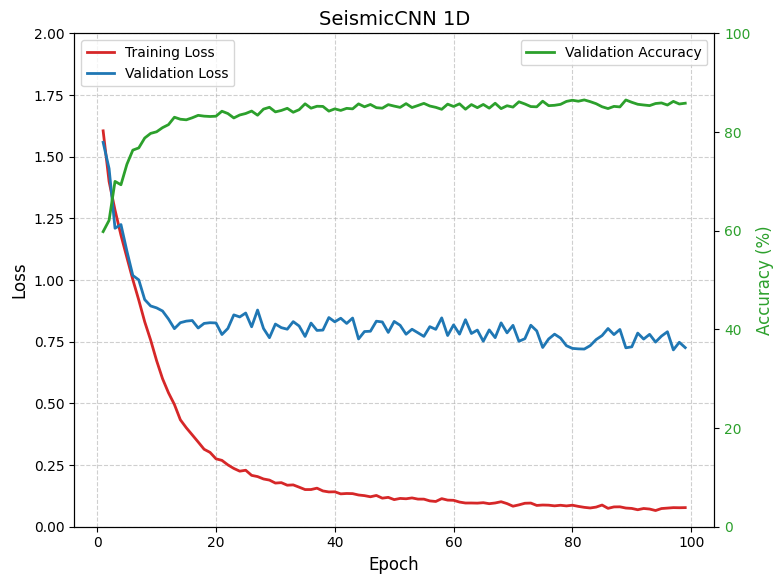

In [23]:
def plot_model_training(loss_time, val_loss_time, val_accuracy_time, title = 'SeismicCNN 1D'):


    # Assuming loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy are defined

    NN = np.count_nonzero(loss_time)
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability

    # Set font sizes
    plt.style.use('default')
    plt.rc('font', size=12)  # Global font size
    plt.rc('axes', titlesize=14)  # Title font size
    plt.rc('axes', labelsize=12)  # Axis label font size
    plt.rc('xtick', labelsize=10)  # X-axis tick label font size
    plt.rc('ytick', labelsize=10)  # Y-axis tick label font size

    # Plot Training and Validation Loss
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.plot(np.arange(1, NN), loss_time[:NN-1], color='tab:red', label='Training Loss', linewidth=2)
    ax1.plot(np.arange(1, NN), val_loss_time[:NN-1], color='tab:blue', label='Validation Loss', linewidth=2)
    #ax1.plot(NN+1, test_loss, 'p', color='tab:blue', label='Test Loss', markersize=10)
    ax1.set_ylim(0, 2)
    ax1.grid(True, linestyle='--', alpha=0.6)  # Add grid with some transparency

    # Twin axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='tab:green')
    ax2.plot(np.arange(1, NN), val_accuracy_time[:NN-1], color='tab:green', label='Validation Accuracy', linewidth=2)
    #ax2.plot(NN+1, test_accuracy, 's', color='tab:green', label='Test Accuracy', markersize=10)
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.grid(False)

    # Title and legend
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add legends for both axes
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    ## Save the figure with high resolution
    #plt.savefig(f"../figures/{title}", dpi=300, bbox_inches='tight')

    plt.show()

plot_model_training(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d)

/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


test loss: 0.407 and accuracy: 86.253


/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


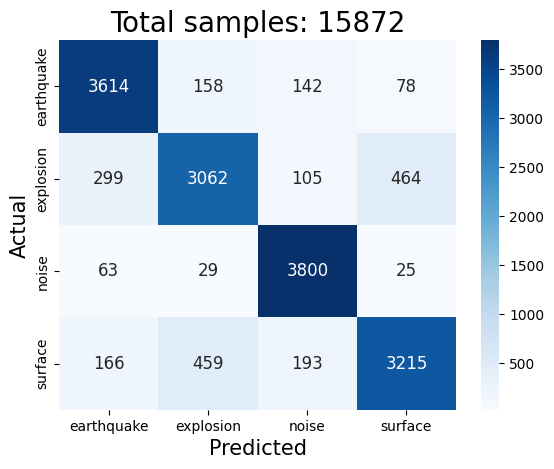

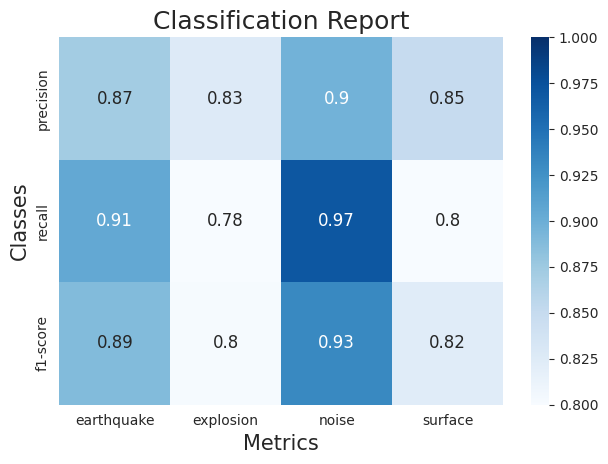

In [24]:
cm_seismiccnn_1d, cr_seismiccnn_1d = plot_confusion_matrix_and_cr(model_seismiccnn_1d, val_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

In [25]:
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, model_training_time_seismiccnn_2d) = train_model_weighted(model_seismiccnn_2d,
    train_loader_2d,  
    val_loader_2d, 
    n_epochs=n_epochs,
    learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = '../trained_models/best_model_new_augmented_esec_exp_weighted_' )

  0%|          | 0/100 [00:00<?, ?it/s]/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
 10%|█         | 10/100 [01:02<09:09,  6.10s/it]

[Epoch 10] loss: 0.789 - accuracy: 82.214


 20%|██        | 20/100 [02:04<08:19,  6.24s/it]

[Epoch 20] loss: 0.602 - accuracy: 85.408


 30%|███       | 30/100 [03:06<07:16,  6.23s/it]

[Epoch 30] loss: 0.503 - accuracy: 86.448


 40%|████      | 40/100 [04:08<06:07,  6.13s/it]

[Epoch 40] loss: 0.438 - accuracy: 87.506


 50%|█████     | 50/100 [05:09<05:08,  6.16s/it]

[Epoch 50] loss: 0.402 - accuracy: 88.017


 60%|██████    | 60/100 [06:11<04:04,  6.11s/it]

[Epoch 60] loss: 0.381 - accuracy: 88.521


 70%|███████   | 70/100 [07:12<03:05,  6.17s/it]

[Epoch 70] loss: 0.349 - accuracy: 88.647


 80%|████████  | 80/100 [08:13<02:02,  6.12s/it]

[Epoch 80] loss: 0.344 - accuracy: 88.716


 90%|█████████ | 90/100 [09:15<01:01,  6.13s/it]

[Epoch 90] loss: 0.326 - accuracy: 89.069


100%|██████████| 100/100 [10:16<00:00,  6.17s/it]

[Epoch 100] loss: 0.315 - accuracy: 88.987


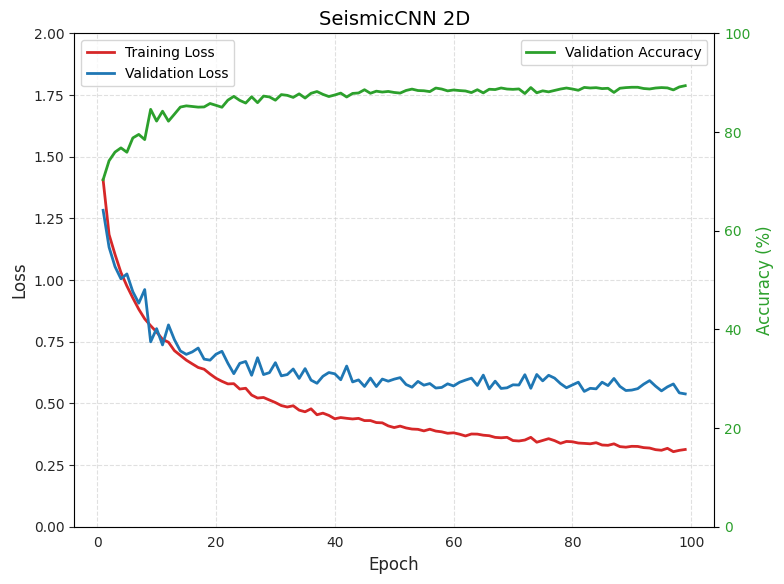

In [26]:
plot_model_training(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, title = 'SeismicCNN 2D') 

/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/utils.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


test loss: 0.362 and accuracy: 89.346


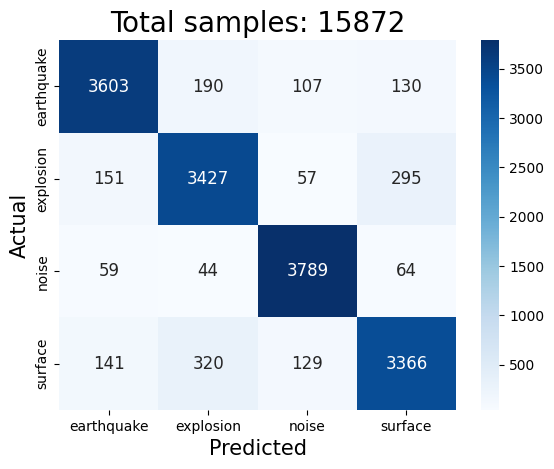

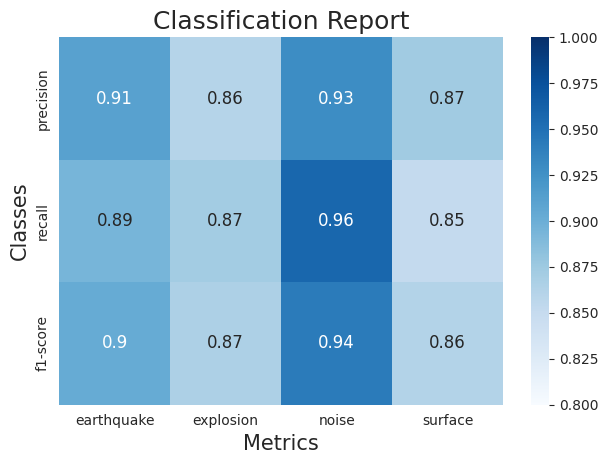

In [27]:
model_seismiccnn_2d.eval()
cm_seismiccnn_2d, cr_seismiccnn_2d = plot_confusion_matrix_and_cr(model_seismiccnn_2d, val_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)